Code for initial Word Embedding Layer 

Work Flow:

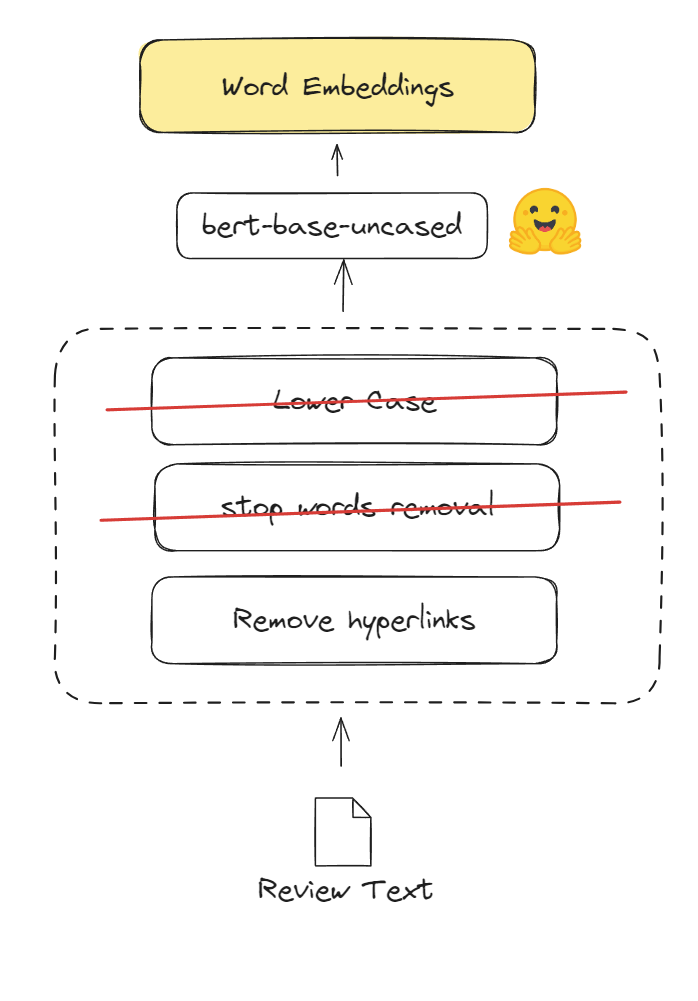

***

In [ ]:
# install relevant libraries / keep our versions consistent 
pip install -r requirements.txt

In [5]:
import pandas as pd 
import numpy as np 
import torch 
import os 
import sys
sys.path.append('../')

import json_reader

ModuleNotFoundError: No module named 'json_reader'

In [5]:
import pandas as pd 
import numpy as np 
import torch 
import os 
import sys
path = os.path.abspath("modules")
sys.path.append(path)

# from gensim.models import Word2Vec
from json_reader import get_df

import pickle 
import re 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
 
import matplotlib.pyplot as plt 
import pickle 

from sentence_transformers import SentenceTransformer


ModuleNotFoundError: No module named 'json_reader'

In [3]:
from modules.json_reader import metadata_loader
metadata = metadata_loader("../raw_data/meta_Video_Games.json.gz").\
           dropna().\
           reset_index(drop=True)
products = metadata[['asin','description']]

In [18]:
# load the data 
df = get_df('raw_data/reviews_Video_Games_5.json.gz').\
    dropna().\
    reset_index(drop=True)

In [53]:
def cleaner(review:str):
   # lower casing the words and removing the puncutations 

   # no links 
   review = re.sub(r'http\S+', '', review)

   # english only no numbers / no puncs 
   # review = re.sub('[^a-zA-Z]+',' ', review.lower())

   # stemming and lemmatization can be considered - performance depends on the usecase and the data nature 
   # https://www.analyticsvidhya.com/blog/2022/06/stemming-vs-lemmatization-in-nlp-must-know-differences/#:~:text=Stemming-,Lemmatization,form%2C%20which%20is%20called%20Lemma.

   # removing the stop words as they contribute no value to the ratings
   # stop_words = set(stopwords.words('english'))
   # results = [word for word in review.strip().split() if word not in stop_words]
   # return " ".join(results)

   return review 

df['reviewText_clean'] = df['reviewText'].apply(cleaner)
products['description_clean'] = products['description'].apply(cleaner)

# exporting to processed_data 
# df.to_csv('processed_Data/processed_data.csv',index=False)

C:\Users\Stevie\AppData\Local\Temp\ipykernel_11604\2277879006.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products['description_clean'] = products['description'].apply(cleaner)


(array([2.13013e+05, 1.30370e+04, 2.15200e+03, 5.14000e+02, 1.42000e+02,
        5.70000e+01, 2.90000e+01, 8.00000e+00, 6.00000e+00, 9.00000e+00]),
 array([    0. ,  2121.3,  4242.6,  6363.9,  8485.2, 10606.5, 12727.8,
        14849.1, 16970.4, 19091.7, 21213. ]),
 <BarContainer object of 10 artists>)

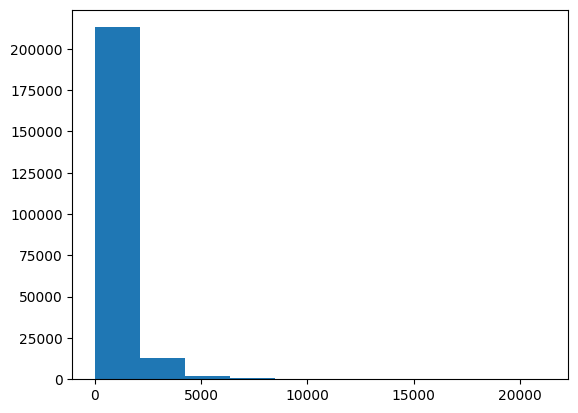

In [20]:
# word length distribution
df['length'] = df['reviewText_clean'].apply(lambda x : len(x))
plt.hist(df.length)

Tried to use Word2Vec, but the results were weird. Probably have some coding mistakes, but i will keep the code here for reference 

In [21]:
# # Using CBOW because we have a lot of training data 
# from gensim.models import Word2Vec
# import multiprocessing

# num_cores = multiprocessing.cpu_count()
# model1 = Word2Vec(df.reviewText_clean, min_count = 1, vector_size=300, window = 10, sg=0, workers=num_cores, sample=1e-5) 
# model1.save('./components/model.bin')
# model = Word2Vec.load('./components/model.bin')

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# https://medium.com/@gulsum.budakoglu/from-sentencetransformer-transformer-and-pooling-components-7d9ad4fcd70f
# u can tune the transformer 
model = SentenceTransformer('bert-base-uncased',device=device)

No sentence-transformers model found with name C:\Users\Stevie/.cache\torch\sentence_transformers\bert-base-uncased. Creating a new one with MEAN pooling.


In [22]:
# creating word embedding with bert-base-uncased 
# https://huggingface.co/bert-base-uncased
embedding = model.encode(df.reviewText_clean.tolist())
product_embedding = model.encode(products.description_clean.tolist())

In [23]:
# creating a list of dicts for reviews 
export_list = []
for i in range(len(df)):
    export = {
        'reviewerID' : df.reviewerID[i],
        'asin' : df.asin[i],
        'reviewText' : df.reviewText[i],
        'reviewText_clean' : df.reviewText_clean[i],
        'embedding' : embedding[i],
        'helpful' : df.helpful[i],
        'overall': df.overall[i]
    }
    export_list.append(export)

# exporting the list as .pkl 
with open('./components/review_embedding.pkl', 'wb') as file:
    pickle.dump(export_list, file)

In [24]:
# loading the .pkl 
with open('./components/review_embedding.pkl', 'rb') as handle:
    x = pickle.load(handle)

pd.DataFrame(x)

,reviewerID,asin,reviewText,reviewText_clean,embedding,helpful,overall
0,A2HD75EMZR8QLN,0700099867,Installing the game was a struggle (because of...,installing game struggle games windows live bu...,"[0.13430683, -0.07392635, 0.60846066, 0.244896...","[8, 12]",1.0
1,A3UR8NLLY1ZHCX,0700099867,If you like rally cars get this game you will ...,like rally cars get game fun oriented european...,"[-0.30108956, -0.18251571, 0.67833704, 0.06144...","[0, 0]",4.0
2,A1INA0F5CWW3J4,0700099867,1st shipment received a book instead of the ga...,st shipment received book instead game nd ship...,"[0.1932246, -0.47946173, 0.5419248, 0.05200587...","[0, 0]",1.0
3,A1DLMTOTHQ4AST,0700099867,"I got this version instead of the PS3 version,...",got version instead ps version turned mistake ...,"[-0.15441999, -0.1123333, 0.75852203, 0.085921...","[7, 10]",3.0
4,A361M14PU2GUEG,0700099867,I had Dirt 2 on Xbox 360 and it was an okay ga...,dirt xbox okay game started playing games lapt...,"[0.16319631, -0.33511886, 0.5559322, 0.3162941...","[2, 2]",4.0
...,...,...,...,...,...,...,...
228962,A1ICREREXO9J81,B00KHECZXO,Funny people on here are rating sellers that a...,funny people rating sellers ripping supposedly...,"[0.047839023, -0.13117597, 0.74617547, 0.21103...","[0, 1]",5.0
228963,A3VVMIMMTYQV5F,B00KHECZXO,All this is is the Deluxe 32GB Wii U with Mari...,deluxe gb wii u mario kart get separately limi...,"[0.09488451, -0.4215225, 0.72942865, 0.3574938...","[8, 11]",1.0
228964,A1DD4B97M4DUC5,B00KHECZXO,The package should have more red on it and sho...,package red show steering wheel retail value s...,"[-0.077871785, -0.2882064, 0.44950223, 0.29391...","[62, 66]",1.0
228965,A2Q9CNJ4T6ZK99,B00KHECZXO,Can get this at Newegg for $329.00 and the pac...,get newegg packaging alittle mine arrived box red,"[0.0123214815, -0.03519188, 0.3560959, -0.0500...","[33, 36]",1.0


In [25]:
# creating a list of dicts for products 
export_list = []
for i in range(len(products)):
    export = {
        'asin' : products.asin[i],
        'description' : products.description[i],
        'description_clean' : products.description_clean[i],
        'embedding' : product_embedding[i],
    }
    export_list.append(export)

# exporting the list as .pkl 
with open('./components/product_embedding.pkl', 'wb') as file:
    pickle.dump(export_list, file)

In [26]:
# loading the .pkl 
with open('./components/product_embedding.pkl', 'rb') as handle:
    x = pickle.load(handle)

pd.DataFrame(x)

,asin,description,description_clean,embedding
0,0078764343,Brand new sealed!,brand new sealed,"[0.16450445, -0.1813381, -0.07640872, 0.084251..."
1,0439591368,Travel to a remarkable new world and treat you...,travel remarkable new world treat brain outlan...,"[-0.26487818, 0.049667332, 0.6012781, 0.110373..."
2,0700026657,"Anno 2070, the newest version of the award-win...",anno newest version award winning real time te...,"[-0.14078505, 0.16780467, 0.7848721, 0.0344406..."
3,0700099867,Dirt 3 is a popular rally racing game for Play...,dirt popular rally racing game playstation com...,"[-0.07106371, 0.13701528, 0.6701784, 0.1738199..."
4,0758534531,This software is BRAND NEW. Packaging may diff...,software brand new packaging may differ slight...,"[0.2803719, 0.21581535, 0.21407071, 0.03005693..."
...,...,...,...,...
16814,B00KGFKGF8,"A prequel to the original Drakengard, Drakenga...",prequel original drakengard drakengard transpo...,"[-0.20028342, -0.079159066, 0.52014977, -0.113..."
16815,B00KHECZXO,Nintendo Wii U 32GB Mario Kart Bundle,nintendo wii u gb mario kart bundle,"[-0.13241243, -0.33519888, 0.6073038, -0.03192..."
16816,B00L2Q5KWE,,,"[-0.009230077, -0.22186233, -0.34482726, 0.016..."
16817,B00L3KU0S8,"Protect your investment!Sleek, minimal and bea...",protect investment sleek minimal beautifully d...,"[-0.006111596, 0.08503663, 0.5942178, 0.094896..."
